In [64]:
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt

Current data is shaped: (1250, 100, 514)


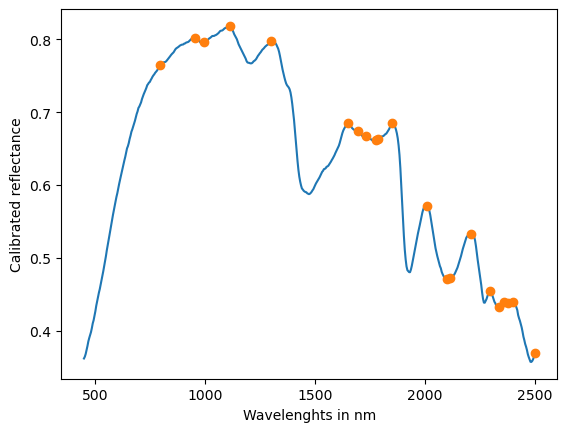

In [65]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 25
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

Current data is shaped: (1250, 100, 514)


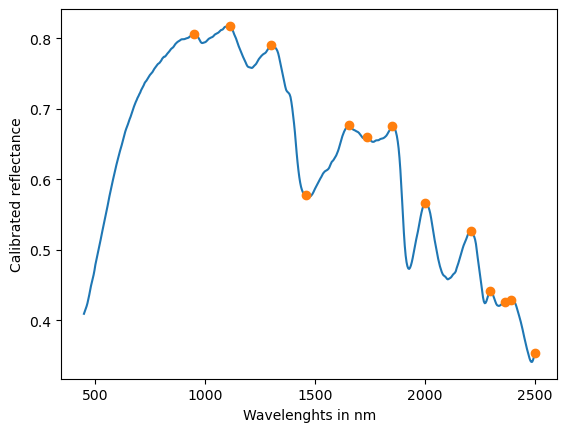

In [10]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 10
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

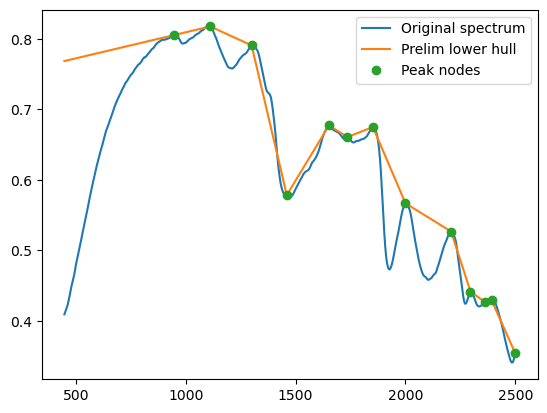

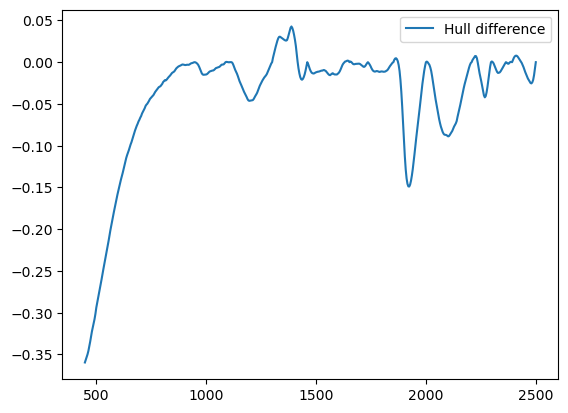

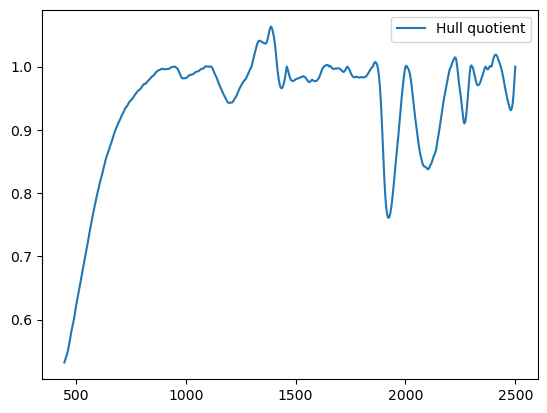

In [61]:
# See an example of interpolation between those peaks

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull

proto_hull = interpolate_linear(curr_pixel,
                                peaks)

plt.plot(wav_array, curr_pixel)
plt.plot(wav_array, proto_hull)
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')
plt.legend(['Original spectrum', 'Prelim lower hull', 'Peak nodes'])

# Example of a hull subtraction

plt.figure()
plt.plot(wav_array, curr_pixel - proto_hull)
plt.legend(['Hull difference'])

# Example of a hull quotient

plt.figure()
plt.plot(wav_array, curr_pixel / proto_hull)
plt.legend(['Hull quotient'])


In [31]:
# Identify cases where this isn't workign well, i.e. zero crossings

def check_zero_crossings(point_set1, point_set2):
    """
    This function checks for zero crossings between two point sets.
    A zero crossing occurs when the difference between the two point sets changes sign.
    
    Parameters:
    point_set1 (numpy array): The first point set.
    point_set2 (numpy array): The second point set.

    Returns:
    numpy array: The indices where zero crossings occur.
    """
    
    # Calculate the difference between the two point sets
    difference = point_set1 - point_set2
    
    # Find the indices where the difference changes sign
    zero_crossings = np.where(np.diff(np.sign(difference)))[0]
    
    return zero_crossings

print(check_zero_crossings(curr_pixel, proto_hull))

# Try an iterative approach to guarantee hull > pixel
fix_vals = []
for val in check_zero_crossings(curr_pixel, proto_hull):
    if curr_pixel[val] > proto_hull[val]:
        fix_vals.append(val)
        
# Reinterpolate by adding only these indices where the hull is currently less than the true spectrum
proto_peaks = np.sort(np.unique(np.concatenate((peaks, np.asarray(fix_vals)))))
proto_hull = interpolate_linear(curr_pixel,
                                peaks)
                      
print(check_zero_crossings(curr_pixel, proto_hull))

# np.concatenate(peaks, np.asarray(fix_vals))


[124 125 159 162 164 165 166 212 213 242 252 253 295 300 301 303 321 322
 350 351 356 387 388 389 439 440 446 461 462 464 478 479 483 485 486 496
 512]
[124 125 159 162 164 165 166 212 213 242 252 253 295 300 301 303 321 322
 350 351 356 387 388 389 439 440 446 461 462 464 478 479 483 485 486 496
 512]
